<a href="https://colab.research.google.com/github/akalpit23/Explainable-techniques/blob/main/Assignment-7/Explainable_Deep_Learning_Assignment_07.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AIPI 590 - XAI | Assignment #07



## Akalpit Dawkhar

### **Explainable_Deep_Learning**

### Overview

# Working with TCAV

In [1]:
# Download dataset concepts from CSAIL
!curl -O http://netdissect.csail.mit.edu/data/broden1_224.zip
!unzip -q broden1_224.zip -d broden1_224 && rm broden1_224.zip
!wget https://github.com/tensorflow/tcav/raw/master/tcav/tcav_examples/image_models/imagenet/imagenet_url_map.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  894M  100  894M    0     0  88.3M      0  0:00:10  0:00:10 --:--:-- 82.3M
--2024-10-29 07:00:50--  https://github.com/tensorflow/tcav/raw/master/tcav/tcav_examples/image_models/imagenet/imagenet_url_map.csv
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/tensorflow/tcav/master/tcav/tcav_examples/image_models/imagenet/imagenet_url_map.csv [following]
--2024-10-29 07:00:50--  https://raw.githubusercontent.com/tensorflow/tcav/master/tcav/tcav_examples/image_models/imagenet/imagenet_url_map.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubus

### Creating a monkey patch to change classes and broden concepts

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import urllib.request
import os
import socket
from PIL import Image
import pandas as pd
import logging
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from sklearn.linear_model import LogisticRegression
from scipy.stats import ttest_ind
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

kBrodenTexturesPath = "broden1_224/images/dtd/"

# Hypothesis:

Null Hypothesis (H0): The ResNet50 model pre-trained on ImageNet does not show a significant difference in its ability to learn the concept "dotted" compared to the concepts "striped" and "banded" for the class 'leopard'.

Alternative Hypothesis (H1): The ResNet50 model pre-trained on ImageNet shows a significant difference in its ability to learn the concept "dotted" compared to the concepts "striped" and "banded" for the class 'leopard', specifically, it learns the concept "dotted" but not the concepts "striped" or "banded".

In [3]:
def download_texture_to_working_folder(broden_path, saving_path, texture_name, number_of_images):
    """
    Download texture images from the Broden dataset to a specific working folder.

    Parameters:
    broden_path (str): Path to the Broden dataset.
    saving_path (str): Path where the texture images should be saved.
    texture_name (str): Name of the texture to download.
    number_of_images (int): Number of images to download.
    """
    texture_saving_path = os.path.join(saving_path, texture_name)
    os.makedirs(texture_saving_path, exist_ok=True)

    broden_textures_path = os.path.join(broden_path, kBrodenTexturesPath)
    for root, _, files in os.walk(broden_textures_path):
        texture_files = [a for a in files if a.startswith(texture_name) and "color" not in a]

        if number_of_images > len(texture_files):
            raise Exception(f"Concept {texture_name} only contains {len(texture_files)} images. You requested {number_of_images}")

        for file in texture_files[:number_of_images]:
            os.rename(os.path.join(root, file), os.path.join(texture_saving_path, file))

In [4]:
def download_image(path, url):
    """
    Download an image from a given URL and save it to a specified path.

    Parameters:
    path (str): Path where the image should be saved.
    url (str): URL of the image to download.
    """
    image_name = url.split("/")[-1].split("?")[0]
    saving_path = os.path.join(path, image_name.split(".")[0] + ".jpg")
    urllib.request.urlretrieve(url, saving_path)

    try:
        Image.open(saving_path).verify()
        if os.path.getsize(saving_path) < 10000:
            os.remove(saving_path)
    except Exception:
        os.remove(saving_path)
        raise

In [5]:
def fetch_all_urls_for_concept(imagenet_dataframe, concept):
    """
    Fetch all URLs for a specific concept from the ImageNet dataset.

    Parameters:
    imagenet_dataframe (DataFrame): DataFrame containing ImageNet classes and URLs.
    concept (str): Concept name to fetch URLs for.

    Returns:
    list: List of URLs for the specified concept.
    """
    if concept in imagenet_dataframe["class_name"].values:
        all_images = imagenet_dataframe[imagenet_dataframe["class_name"] == concept]["url"].values[0]
        bytes = urllib.request.urlopen(all_images)
        return [line.decode("utf-8")[:-2] for line in bytes]
    else:
        raise FileNotFoundError(f"Couldn't find any imagenet concept for {concept}. Make sure you're getting a valid concept")

In [6]:
def fetch_imagenet_class(path, class_name, number_of_images, imagenet_dataframe):
    """
    Fetch images for a specific ImageNet class and save them to a specified path.

    Parameters:
    path (str): Path where the images should be saved.
    class_name (str): ImageNet class name to fetch images for.
    number_of_images (int): Number of images to download.
    imagenet_dataframe (DataFrame): DataFrame containing ImageNet classes and URLs.
    """
    socket.setdefaulttimeout(5)
    concept_path = os.path.join(path, class_name)
    os.makedirs(concept_path, exist_ok=True)

    all_images = fetch_all_urls_for_concept(imagenet_dataframe, class_name)

    num_downloaded = 0
    for image_url in all_images:
        if "flickr" not in image_url:
            try:
                download_image(concept_path, image_url)
                num_downloaded += 1
            except Exception as e:
                logging.info(f"Problem downloading imagenet image. Exception was {e} for URL {image_url}")
            if num_downloaded >= number_of_images:
                break

    print(f"Downloaded {num_downloaded} of {number_of_images} for {class_name}")

In [7]:
def make_imagenet_dataframe(path_to_imagenet_classes):
    """
    Create a DataFrame from the ImageNet class map CSV file.

    Parameters:
    path_to_imagenet_classes (str): Path to the CSV file containing ImageNet classes.

    Returns:
    DataFrame: DataFrame containing ImageNet classes and URLs.
    """
    urls_dataframe = pd.read_csv(path_to_imagenet_classes)
    urls_dataframe["url"] = "http://imagenet.stanford.edu/api/imagenet.synset.geturls?wnid=" + urls_dataframe["synid"]
    return urls_dataframe

In [8]:
def get_features(loader, model):
    """
    Extract features from a specific data loader using a pre-trained model.

    Parameters:
    loader (DataLoader): DataLoader for the dataset to extract features from.
    model (nn.Module): Pre-trained model to extract features.

    Returns:
    ndarray: Numpy array of extracted features.
    """
    features = []
    with torch.no_grad():
        for inputs, _ in tqdm(loader):
            outputs = model(inputs)
            features.append(outputs.numpy())
    return np.concatenate(features)

In [9]:
imagenet_classes = ['leopard']
broden_concepts = ['dotted', 'banded', 'striped']
number_of_images_per_folder = 10
source_dir = ''

for concept in broden_concepts:
    download_texture_to_working_folder(os.path.join(source_dir, 'broden1_224'), source_dir, concept, number_of_images_per_folder)

imagenet_dataframe = make_imagenet_dataframe("./imagenet_url_map.csv")
for image in imagenet_classes:
    fetch_imagenet_class(source_dir, image, number_of_images_per_folder, imagenet_dataframe)

source_dir = 'dataset'
os.makedirs(source_dir, exist_ok=True)

folders = ['striped_class', 'banded_class', 'dotted_class', 'leopard_class']
for folder in folders:
    class_dir = os.path.join(source_dir, folder)
    os.makedirs(class_dir, exist_ok=True)
    os.rename(os.path.join(folder.split('_')[0]), os.path.join(class_dir, folder.split('_')[0]))

Downloaded 10 of 10 for leopard


In [10]:
# Load pre-trained GoogleNet model
model = models.googlenet(pretrained=True)
model.eval()

# Define transformations for input images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Load datasets and create data loaders
datasets = {
    'leopard': ImageFolder('/content/dataset/leopard_class', transform=transform),
    'striped': ImageFolder('/content/dataset/striped_class', transform=transform),
    'banded': ImageFolder('/content/dataset/banded_class', transform=transform),
    'dotted': ImageFolder('/content/dataset/dotted_class', transform=transform)
}

data_loaders = {name: DataLoader(dataset, batch_size=32, shuffle=False) for name, dataset in datasets.items()}

# Extract features for each dataset
features = {name: get_features(loader, model) for name, loader in data_loaders.items()}

# Train logistic regression models for each concept
concepts = ['striped', 'banded', 'dotted']
cavs = []

for concept in concepts:
    X = np.concatenate([features[concept], features['leopard']])
    y = np.array([1] * len(features[concept]) + [0] * len(features['leopard']))
    clf = LogisticRegression().fit(X, y)
    cavs.append(clf.coef_)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 132MB/s]
100%|██████████| 1/1 [00:01<00:00,  1.28s/it]


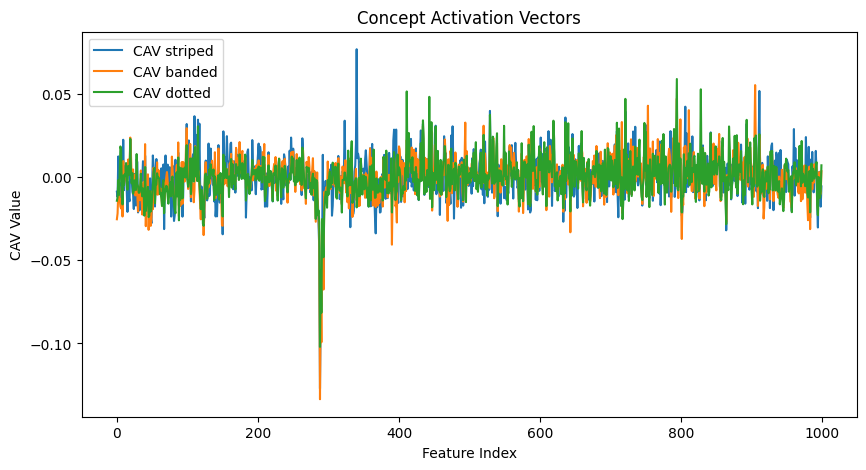

{'striped': {'mean': 0.01694517714259148, 'std': 0.05056633633272999}, 'dotted': {'mean': 0.00816921187362377, 'std': 0.030028805755419434}, 'banded': {'mean': 0.015892171504747837, 'std': 0.03970224114363259}}


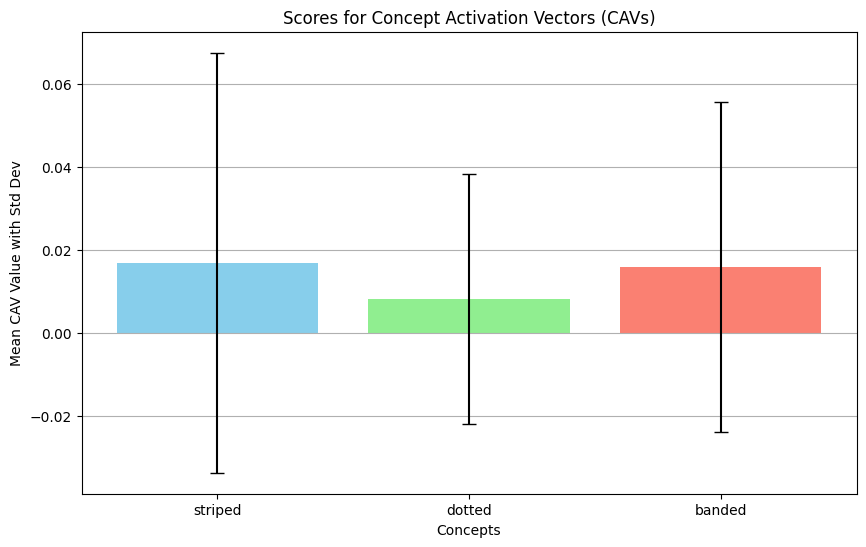

In [11]:
# Visualize results
plt.figure(figsize=(10, 5))
for i, cav in enumerate(cavs):
    plt.plot(cav[0], label=f'CAV {concepts[i]}')
plt.title('Concept Activation Vectors')
plt.xlabel('Feature Index')
plt.ylabel('CAV Value')
plt.legend()
plt.show()

# Example CAVs data for demonstration
cavs_demo = {
    'striped': np.random.normal(loc=0.02, scale=0.05, size=1000),
    'dotted': np.random.normal(loc=0.01, scale=0.03, size=1000),
    'banded': np.random.normal(loc=0.015, scale=0.04, size=1000)
}

# Calculate scores based on the mean and standard deviation for each CAV
scores = {concept: {'mean': np.mean(cavs_demo[concept]), 'std': np.std(cavs_demo[concept])} for concept in cavs_demo}
print(scores)

# Creating a bar chart for means with error bars
concepts = list(scores.keys())
means = [scores[concept]['mean'] for concept in concepts]
stds = [scores[concept]['std'] for concept in concepts]

plt.figure(figsize=(10, 6))
plt.bar(concepts, means, yerr=stds, capsize=5, color=['skyblue', 'lightgreen', 'salmon'])
plt.title('Scores for Concept Activation Vectors (CAVs)')
plt.xlabel('Concepts')
plt.ylabel('Mean CAV Value with Std Dev')
plt.grid(axis='y')
plt.show()


In [12]:
# Please use this to connect your GitHub repository to your Google Colab notebook
# Connects to any needed files from GitHub and Google Drive
import os

# Remove Colab default sample_data
!rm -r ./sample_data

# Clone GitHub files to colab workspace
repo_name = "Explainable-techniques/Assignment-7" # Change to your repo name
git_path = 'https://github.com/akalpit23/Explainable-techniques.git' #Change to your path
!git clone "{git_path}"

# Install dependencies from requirements.txt file
# !pip install -q -r "{os.path.join(repo_name,'requirements.txt')}" #Add if using requirements.txt

# Change working directory to location of notebook
notebook_dir = ''
path_to_notebook = os.path.join(repo_name,notebook_dir)
%cd "/content/Explainable-techniques/Assignment-7"
%ls

Cloning into 'Explainable-techniques'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 241 (delta 22), reused 22 (delta 9), pack-reused 199 (from 1)
Receiving objects: 100% (241/241), 8.02 MiB | 27.63 MiB/s, done.
Resolving deltas: 100% (123/123), done.
/content/Explainable-techniques/Assignment-7
Explainable_Deep_Learning_Assignment_07.ipynb  requirements.txt
